In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import cv2 as cv
%matplotlib inline

In [2]:
def max_contrast(img):
    
    """
    
        maximize contrast of images
        also deleting "edges"
        
    """
    
    img[img == img[0,0]] = 0
    
    mi,ma = img.min(),img.max()
    if ma == 0:
        return img
    
    img -= mi
    img[img == ma -mi] = 0
    ma = img.max()
    img = np.array(((img / ma) * 255),dtype='uint8')
    return img

def binary(img,threshold=5):
    img[img > threshold ] = 255
    img[img <= threshold] = 0
    return img


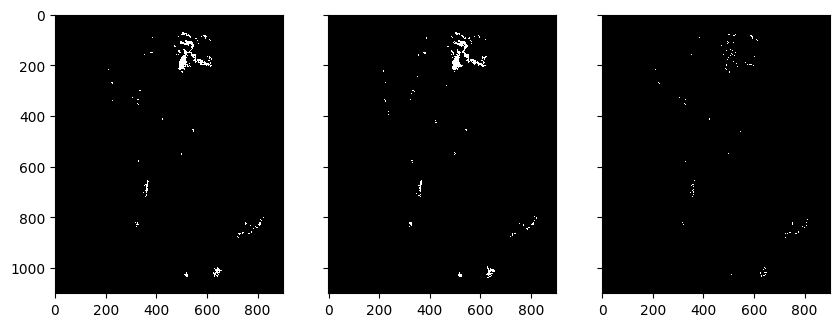

In [3]:
path = "PNG"

"""

        Plot difference between two images

"""

fig, axes = plt.subplots(1, 3, figsize=(10, 10),dpi=100, sharex=False, sharey=True)
img_0 = Image.open(os.path.join(path,"scaled_1705140100.png"))
img_1 = Image.open(os.path.join(path,"scaled_1705140105.png"))
img_0 = max_contrast(np.array(img_0))
img_0 = np.array(img_0)
img_1 = max_contrast(np.array(img_1))
img_0 = binary(img_0)
img_1 = binary(img_1)
axes[0].imshow(img_0,cmap="gray")
axes[1].imshow(img_1,cmap="gray")
axes[2].imshow(np.abs(img_0-img_1),cmap="gray")
plt.show()

In [4]:
def get_files(pwd,pattern=""):
    
    """
    
        Read all files from path which match a pattern and return a list with the names
    
    """
    
    import re
    files = []
    for file in os.listdir(pwd):
        matches = re.search(pattern, file)
        if matches:
            files.append(matches[0])
    files.sort()
    return files

files = get_files(path,pattern="scaled_17051.*")

def show_series(function):
    
    """
        
        shows a series of images,
        function should return images
    
    """
    
    windowname = 'OpenCvFrame'
    cv.namedWindow(windowname)
    cv.moveWindow(windowname,2600,40)
    ret = True

    while(ret):
        for file in files:
            frame = function(file)
            cv.imshow(windowname, frame)

            if cv.waitKey(25) & 0XFF == ord('q'):
                ret = False
                break


    cv.destroyAllWindows()


In [5]:
from skimage import measure
scale = 10
random_color = [list(np.random.choice(range(256), size=3)) for i in range(0,2000)]
def f(file):
    frame = Image.open(os.path.join(path,file))
    frame = max_contrast(np.array(frame))
    frame = binary(frame)
    frame = naive_clustering(frame,max_dist = 2)
    return frame

def naive_clustering(image,max_dist = 1):
    
    """
        
        Cluster clouds by 
    
    """

    if scale > 0:
        downscale = scale

        w = image.shape[1]
        h = image.shape[0]
        
        width = int(image.shape[1] * downscale / 100)
        height = int(image.shape[0] * downscale / 100)
        dim = (width, height)
        image = cv.resize(image, dim, interpolation = cv.INTER_AREA)
        


    
    img_labeled = measure.label(image, background = 0 ,connectivity=2)

    # Get the indices for each region, excluding zeros
    idx = [np.where(img_labeled == label)
           for label in np.unique(img_labeled)
           if label]


    # Get the bounding boxes of each region (ignoring zeros)
    bboxes = [area.bbox for area in measure.regionprops(img_labeled)]
    image = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    #for i,box in enumerate(bboxes):
        #image[box[0]:box[2],box[1]:box[3]] = [255,0,0]
        #image[box[0]:box[2],box[1]:box[3]] = random_color[i]
        
    #if scale > 0:
        # resize image
        #image = cv.resize(image, (w,h), interpolation = cv.INTER_AREA) 
        
    #return image
    
    for i,pair in enumerate(idx):
        image[pair] = random_color[i]
        #image[pair] = 255
    if scale > 0:
        # resize image
        image = cv.resize(image, (w,h), interpolation = cv.INTER_AREA) 
    return image


In [6]:
scale = 30
#show_series(f)

In [124]:
scale = 30
def create_GIF(function,name="clouds.gif",nbr_imgs = 0):

    
    def create(inputPath, outputPath, delay, finalDelay, loop):
        cmd = "convert -delay {} {}*.png -delay {} -loop {} {}".format(
        delay, inputPath, finalDelay, loop,
        outputPath)
        os.system(cmd)

    folder = "GIF/"
    if not os.path.exists(folder):
        os.mkdir(folder)
    files.sort()
    for i,file in enumerate(files):
        original = Image.open(os.path.join(path,file))
        original = np.array(original)
        original[original != 0] = 255
        img = function(file)
        original = cv.cvtColor(original,cv.COLOR_GRAY2RGB)
        
        concat = np.concatenate((original,img),axis=1)
        cv.imwrite(os.path.join(folder,file),concat)
        if i == nbr_imgs and nbr_imgs != 0:
            break
    create(folder,name,10,250,0)
    



In [126]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        if stop_val > 255:
            stop_val = 255
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        rgb = list(self.scalarMap.to_rgba(val))[:3]
        ret = [int(i * 255) for i in rgb]
        #return rgb
        return [int(rgb[0]*255),int(rgb[1]*255),int(rgb[2]*255)]


def sequentialLabeling(img,max_dist=1):

    def consecutive(data, stepsize=1):
        return np.split(data, np.where(np.diff(data) == stepsize)[0]+1)

    img[img >= 5] = 1
    x,y = np.where(img == 1)

    
    collision = dict()
    label = 2

    for i,j in zip(x,y):
        i_X = slice(i-max_dist,i+max_dist)
        j_Y = slice(j-max_dist,j+max_dist)
        
        window = img[i_X,j_Y]
        
        neighbours = np.argwhere(window > 1)
        
        
        if len(neighbours) == 0:
            window[window == 1] = label
            label +=1
            img[i_X,j_Y] = window
            
        elif len(neighbours) == 1:
            window[window == 1] = window[neighbours[0,0],neighbours[0,1]]
            img[i_X,j_Y] = window
        
        
        # handle label collisions
        
        else:
            k = np.amax(window)
            img[i,j] = k
            for index in neighbours:
                nj = window[index[0], index[1]]
                        
                if nj != k:
                    if k not in collision:
                        collision[k] = set()
                    collision[k].add(nj)
                    if collision[k] is None:
                        del collision[k]

    
    
    def changeLabel(elem):
        c_label = collision[elem]
        for l in c_label:
            img[img == l] = elem
    
    
    new_coldict = {}
    

    def rearangeCollisions():
        for elem in collision:
            for item in collision[elem]:
                if item in collision:
                    collision[elem] = (collision[elem] | collision[item])
                    collision[item] = set()
            if elem in collision[elem]:
                collision[elem].remove(elem)
            
    rearangeCollisions()
    
    
    for i,elem in enumerate(collision):
        if collision[elem] is None:
            continue
        changeLabel(elem)


        


    # paint clouds according to their size
    
    cloud_size = []
    
    for i in range(2,label):
        a = len(np.where(img == i)[0])
        if a == 0:
            continue
        cloud_size.append((i,a))
        
    cloud_size = sorted(cloud_size, key=lambda x: x[1])

    COL = MplColorHelper('hsv', 0, len(cloud_size))
    
    colors = {}
    for i,elem in enumerate(cloud_size):
        colors[elem[1]] = COL.get_rgb(i)
     
    img = cv.cvtColor(img,cv.COLOR_GRAY2RGB)
    
    for label,size in cloud_size:
        img[np.where(img[:,:,0] == label)] = colors[size]


    return img


    
    

def tracking(file,scale = 0.0):
    frame = Image.open(os.path.join(path,file))
    frame = max_contrast(np.array(frame))
    frame = binary(frame)
    
    if scale > 0.0:
        h,w = frame.shape[:2]
        frame = cv.resize(frame,(int(w * scale),int(h * scale)))
        
    
    frame = sequentialLabeling(frame,max_dist = 10)
    
    if scale > 0.0:
        frame = cv.resize(frame,(w,h))
        
    return frame

show_series(tracking)

In [127]:
create_GIF(tracking,nbr_imgs=500)